# Calculation of Transport, Transport Streamfunction, and Maximum Transport Streamfunction for 35N in ECCO V4r4

Ian Fenty 2021-06-10 for Isabela Le Bras

## Load Libraries

In [2]:
import pandas as pd
import sys

# Download the ECCOv4-py library from https://github.com/ECCO-GROUP/ECCOv4-py
sys.path.append('/vortexfs1/home/ilebras/ECCOv4-py')
import ecco_v4_py as ecco

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

import matplotlib.pyplot as plt
import json
import time

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

import cartopy as cart
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

## Dask Configuration

In [3]:
## the dask library allows one to operate on many large files without loading them all into memory at once
import dask
from dask.distributed import Client, progress

# define a temporary scratch directory for Dask
dask.config.set({'temporary_directory': '/vortexfs1/scratch/ilebras/ECCO/'})

## dask options
#--------------------
## Option 1: you have a machine with a lot of memory
## (example for Ian's Machine, but not necessary)

client = Client(processes=False, n_workers=1, threads_per_worker=8,memory_limit='20GB')

## Option 2: you don't have a ton of memory, this option should work fine
# client = Client(processes=False, n_workers=1, threads_per_worker=1)

print(client)

<Client: 'inproc://10.141.0.97/401123/1' processes=1 threads=8, memory=20.00 GB>


## Load the grid file and specify locations of ECCO files

In [4]:
ecco_root_dir = Path('/vortexfs1/home/ilebras/data/ECCO/v4r4_downloaded_from_cloud/')

## Download the 3D Volume flux and the ECCO GEOMETRY file using the instructions from the other notebooks

# directory with ECCO grid geometry for the llc90 model
ecco_grid_dir = ecco_root_dir / 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4'

# directory with monthly-mean volume fluxes
vol_flux_dir  = ecco_root_dir / 'ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4'

## load the ECCO grid geometry file
ecco_grid = xr.open_dataset(ecco_grid_dir / 'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc').load()

## Basin Definition

In [5]:
# We want to calculate MOC for 35N in the Atlantic. 
# To separate the Atlantic from other basins we have to create a basin mask
# the ECCOv4-py library has several basin masks pre-installed
basins=ecco.get_available_basin_names()
for b in basins:
   print(b)

# we'll use the Atlantic 
basin = 'atl'

# year range of analysis
years_2_analyze=range(1992,2020)

pac
atl
ind
arct
bering
southChina
mexico
okhotsk
hudson
med
java
north
japan
timor
eastChina
red
gulf
baffin
gin
barents


In [6]:
# load the basin mask
basin_name = basin
basin_mask = ecco.get_basin_mask(basin,ecco_grid.maskC)

get_basin_name:  ['atl'] /vortexfs1/home/ilebras/ECCOv4-py/binary_data
load_binary_array: loading file /vortexfs1/home/ilebras/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)


## Routine to load volume flux files using xarray

In [7]:
def load_vol_fluxes(vol_flux_dir):
    time_start=time.time()

    # opening 312 monthly mean files takes about 40s using parallel & dask

    vol_flux_files = list(vol_flux_dir.glob('OCEAN*nc'))
    vol_fluxes = xr.open_mfdataset(vol_flux_files,parallel=True, data_vars='minimal',\
                                  coords='minimal',compat='override')
    
    tt = time.time() - time_start    
    print(tt / len(vol_flux_files))
    print('time to index (not exactly read) the files (s)', time.time() - time_start)
    
    return vol_fluxes

## Load Volume Fluxes

In [8]:
# load vol_fluxes using parallel and dask.  It takes about 30 seconds on my machine
vol_fluxes = load_vol_fluxes(vol_flux_dir)

0.2637759716280045
time to index (not exactly read) the files (s) 81.77079749107361


notice how the arrays are 'dask.array' objects.  these allow you to operate on many very large datasets without loading them all into memory at once

## Merge the volume flux and ecco grid objects

In [9]:
# merge the vol_fluxes DataSet with the ecco_grid DataSet.
ecco_data_mon_mean=ecco_grid.combine_first(vol_fluxes)

In [10]:
ds=ecco_data_mon_mean

## Plot the section of interest [35N]

In [11]:
basedir='/vortexfs1/home/ilebras/'
datadir=basedir+'data/'
figdir=basedir+'figures/NASA_AMOC/August2022_bathy/'
LWmerge=xr.open_dataset(datadir+'NASA_AMOC/Section35N_Step3.nc')

In [12]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90+new_grid_delta_lat/2
new_grid_max_lat = 90-new_grid_delta_lat/2

new_grid_min_lon = -180+new_grid_delta_lon/2
new_grid_max_lon = 180-new_grid_delta_lon/2

new_lon,new_lat,new_mid_lon,new_mid_lat,ecco_bathy_array=ecco.resample_to_latlon(ds.XC,\
                                ds.YC,\
                                ds.Depth,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

-179.0 179.0
-179.5 179.5
-89.0 89.0
-89.5 89.5


In [13]:
np.shape(new_lon[0,:])
np.shape(new_lat[:,0])
np.shape(ecco_bathy_array)

(179, 359)

In [14]:
ecco_bathy=xr.DataArray(ecco_bathy_array,coords={'lon':new_lon[0,:],'lat':new_lat[:,0]},dims=['lat','lon'])

In [15]:
ecco_bathy_interp=-ecco_bathy.interp(lon=LWmerge.loni,lat=LWmerge.lat)

In [16]:
LWmerge.bathy_i.interp(dist=335)

<xarray.DataArray 'bathy_i' ()>
array(-4609.27661276)
Coordinates:
    lat      float64 37.63
    loni     float64 -68.32
    dist     int64 335

In [17]:
ecco_bathy_interp.interp(dist=397)

<xarray.DataArray ()>
array(-4613.81437266)
Coordinates:
    lon      float64 -67.97
    lat      float64 37.15
    loni     float64 -67.97
    dist     int64 397

In [18]:
LWmerge.loni.interp(dist=397)

<xarray.DataArray 'loni' ()>
array(-67.97155973)
Coordinates:
    lat      float64 37.15
    loni     float64 -67.97
    dist     int64 397

In [19]:
LWmerge.lat.interp(dist=397)

<xarray.DataArray 'lat' ()>
array(37.14820556)
Coordinates:
    lat      float64 37.15
    loni     float64 -67.97
    dist     int64 397

#### Piece together MOC in shorter chunks

In [20]:
LWmerge.loni[-5:]

<xarray.DataArray 'loni' (dist: 5)>
array([-7.125, -6.875, -6.625, -6.375, -6.125])
Coordinates:
    lat      (dist) float64 35.0 35.0 35.0 35.0 35.0
    loni     (dist) float64 -7.125 -6.875 -6.625 -6.375 -6.125
  * dist     (dist) float64 6.073e+03 6.096e+03 6.118e+03 6.141e+03 6.164e+03

In [25]:
xr.concat([LWmerge.loni[::5],LWmerge.loni[-1]],dim='dist').values

array([-70.2       , -69.72634987, -69.22327815, -68.72693139,
       -68.2       , -67.7       , -67.2       , -66.7       ,
       -65.875     , -64.625     , -63.375     , -62.125     ,
       -60.875     , -59.625     , -58.375     , -57.125     ,
       -55.875     , -54.625     , -53.375     , -52.125     ,
       -50.875     , -49.625     , -48.375     , -47.125     ,
       -45.875     , -44.625     , -43.375     , -42.125     ,
       -40.875     , -39.625     , -38.375     , -37.125     ,
       -35.875     , -34.625     , -33.375     , -32.125     ,
       -30.875     , -29.625     , -28.375     , -27.125     ,
       -25.875     , -24.625     , -23.375     , -22.125     ,
       -20.875     , -19.625     , -18.375     , -17.125     ,
       -15.875     , -14.625     , -13.375     , -12.125     ,
       -10.875     ,  -9.625     ,  -8.375     ,  -7.125     ,
        -6.125     ])

In [26]:
ecco_lon=xr.concat([LWmerge.loni[::5],LWmerge.loni[-1]],dim='dist').values

In [27]:
ecco_lat=xr.concat([LWmerge.lat[::5],LWmerge.lat[-1]],dim='dist').values

In [28]:
xport={}
for ii in range(len(ecco_lon))[:-1]:
    xport[ii]=ecco.calc_section_stf(ecco_data_mon_mean,[ecco_lon[ii],ecco_lat[ii]],[ecco_lon[ii+1],ecco_lat[ii+1]])

Get AMOC metrics

In [29]:
ecco_35N=xport[0].trsp_z+xport[1].trsp_z
for ii in list(xport.keys())[2:]:
    ecco_35N=ecco_35N+xport[ii].trsp_z

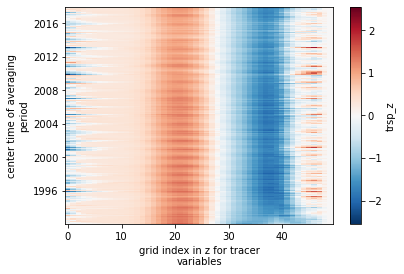

In [30]:
ecco_35N.plot()

In [31]:
ecco_35N=ecco_35N.swap_dims({'k':'Z'})

In [32]:
ecco35_psi=ecco_35N.cumsum(dim='Z')-ecco_35N.sum(dim='Z')
ecco35_moc=ecco35_psi.max(dim='Z')

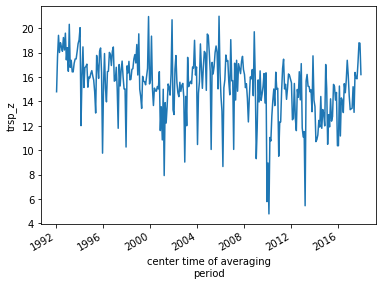

In [33]:
ecco35_moc.plot()

Get volume transport below 1000m along the section

In [34]:
deep_flow_mat=np.ones((len(xport[0].time),len(ecco_lon)))

In [35]:
for ii in xport:
    deep_flow_mat[:,ii]=xport[ii].trsp_z.swap_dims({'k':'Z'}).sel(Z=slice(-1e3,-6e3)).sum(dim='Z')

In [38]:
deep_flow=xr.DataArray(data=deep_flow_mat, coords=[("time",xport[0].time.values), ("dist",xr.concat([LWmerge.dist[::5],LWmerge.dist[-1]],dim='dist').values)])

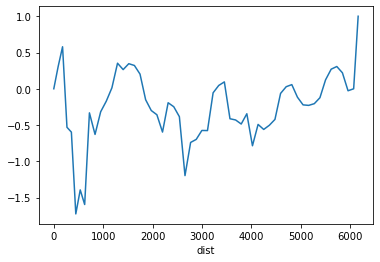

In [39]:
deep_flow.mean(dim='time').plot()

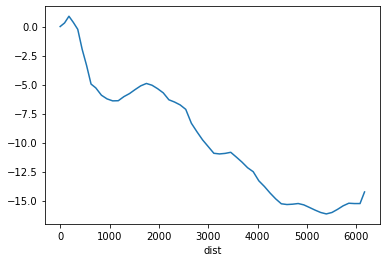

In [40]:
deep_flow.cumsum(dim='dist').mean(dim='time').plot()

## Save results

In [41]:
# save the output for later analysis
intermediate_calculations_dir = '/vortexfs1/home/ilebras/data/ECCO/intermediate_calcs/'

# save result as a netcdf file
deep_flow.to_netcdf(intermediate_calculations_dir+'ecco_35MOC_deepflow.nc')

In [ ]:
# ecco35_psi.to_netcdf(intermediate_calculations_dir+'ecco_35MOC_psi.nc')
# ecco35_moc.to_netcdf(intermediate_calculations_dir+'ecco_35MOC.nc')

In [43]:
ecco_bathy_interp.to_netcdf(intermediate_calculations_dir+'ecco_bathy_35interp.nc')